In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from train_simclr import train

cuda


## Data augmentation

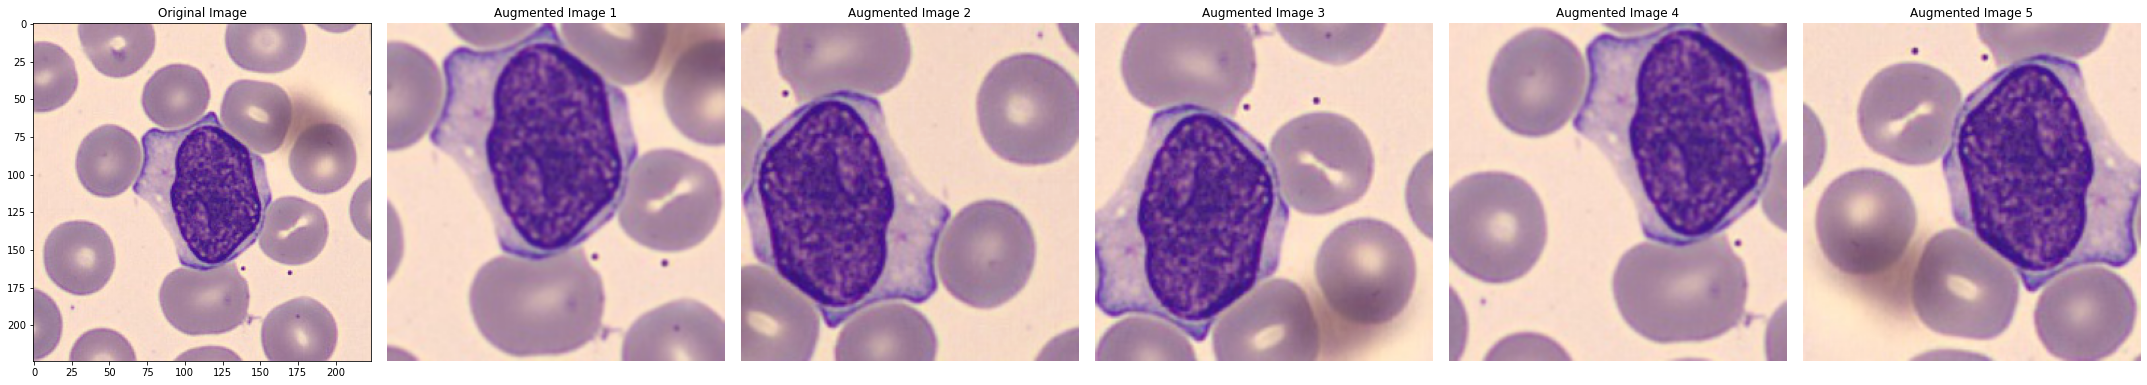

In [3]:
# Load the image
# image_path = "beagle-hound-dog.png"
image_path = "../dataset/trainset/P0/000000.jpg"
image = Image.open(image_path)

# Define the transformations
transform = transforms.Compose([
    transforms.RandomCrop(150),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
    transforms.ToTensor()
])

# Create a figure with subplots for each augmented image
num_examples = 5
fig, axes = plt.subplots(1, num_examples + 1, figsize=(5 * (num_examples + 1), 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
for i in range(num_examples):
    augmented_image = transform(image)
    axes[i + 1].imshow(augmented_image.permute(1, 2, 0))
    axes[i + 1].set_title(f"Augmented Image {i + 1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

In [4]:
from simclr import SimCLR
from train_simclr import train
from contrastive_loss import LARS,ContrastiveLoss

## Load and Visualize the data

In this section, we want to define our data loader and visualize some examples of the two classes.

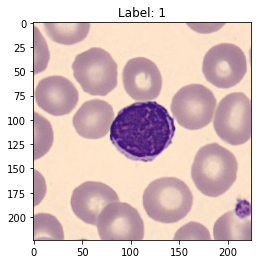

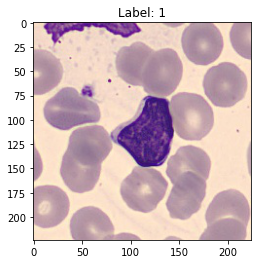

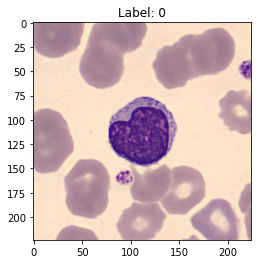

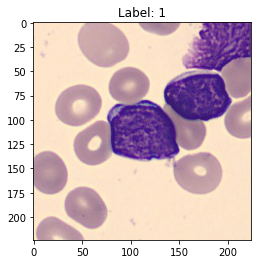

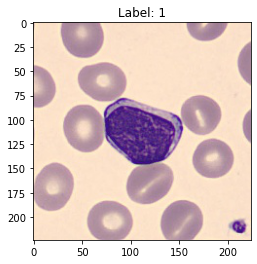

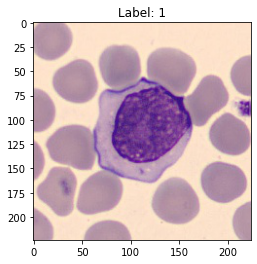

In [5]:
# Load the dataset
train_folder = "../dataset_2/dataset/trainset"

transform = transforms.ToTensor()
dataset = ImageFolder(train_folder, transform=transform)

batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Display some examples
k=0
for images, labels in data_loader:
    image = images[0].permute(1, 2, 0)
    plt.imshow(image)
    plt.title(f"Label: {labels[0]}")
    plt.show()
    k+=1
    if k > 5:
        break

## Instantiating the model & defining the parameters

In [6]:
embeddings_dim = 256
projection_dim = 512

# Define the backbone as a ResNet18
encoder = models.resnet18(pretrained=True)
num_features = encoder.fc.in_features
encoder.fc = nn.Linear(num_features, embeddings_dim)

# Define the projection head as two linear layers with ReLU activation
head = nn.Sequential(
    nn.Linear(embeddings_dim, 256),
    nn.ReLU(),
    nn.Linear(256, projection_dim)
)

c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
nb_channels, nb_rows, nb_columns = 3, 190, 190

model = SimCLR(encoder, head, nb_channels, nb_rows, nb_columns)
model.to(device)

criterion = ContrastiveLoss(batch_size, temperature=0.5)
optimizer = LARS(model.parameters(), lr=0.003)

## Training loop

In [ ]:
num_epochs = 100
losses = []


for epoch in tqdm(range(num_epochs), desc="Epochs"):
    running_loss = 0.0
    for image, label in data_loader:
        image = image.to(device)
        optimizer.zero_grad()

        # Forward pass: randomly augment two views from the same image
        z1 = model(image)
        z2 = model(image)

        loss = criterion(z1, z2)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch%10 == 0:
      epoch_loss = running_loss / len(data_loader)
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    losses.append(running_loss / len(data_loader))
    
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')